# Capstone Project - Signature Verification using SVM
* Trained on 14,916 offline signature images (Genuine + Forged)
* Author: Nishant Dalal, Aniket Chaudhary, Dev Rana
* Accuracy: 91% | Precision: 89% | Recall: 90% | F1-Score: 87%

In [31]:
!pip install scikit-image

In [32]:
dataset_path = "/Users/nishantdalal/Downloads/extracted_dataset"

In [33]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from skimage.feature import hog

In [34]:
def extract_features(img):
    img_resized = cv2.resize(img, (64, 64))

    hu = cv2.HuMoments(cv2.moments(img_resized)).flatten()
    hog_features = hog(img_resized,
                       orientations=9,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       block_norm='L2-Hys',
                       visualize=False)

    return np.concatenate([hu, hog_features])

In [35]:
def load_images_with_features(folder, label):
    data, labels = [], []
    for filename in tqdm(os.listdir(folder), desc=f"Processing {label}"):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            features = extract_features(img)
            data.append(features)
            labels.append(label)
    return data, labels

forged_path = os.path.join(dataset_path, 'forged')
genuine_path = os.path.join(dataset_path, 'genuine')

forged_data, forged_labels = load_images_with_features(forged_path, 0)
genuine_data, genuine_labels = load_images_with_features(genuine_path, 1)

X = np.array(forged_data + genuine_data)
y = np.array(forged_labels + genuine_labels)

print("Dataset Loaded. Total Samples:", X.shape[0], " | Feature Length:", X.shape[1])

Processing 0:   0%|          | 0/7458 [00:00<?, ?it/s]

Processing 1: 100%|██████████| 7458/7458 [00:09<00:00, 772.34it/s]


Dataset Loaded. Total Samples: 14916  | Feature Length: 1771


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
import time

# define hyperparameters
params = {
    'C': [1, 10, 100],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

total_combos = len(params['C']) * len(params['gamma']) * len(params['kernel'])

print("Starting Grid Search...")
print(f"Total combinations to try: {total_combos}")
print(f"Expected fits (with 3-fold CV): {total_combos * 3}\n")

start_time = time.time()

# grid Search with cross-validation
grid = GridSearchCV(
    estimator=SVC(),
    param_grid=params,
    cv=3,
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)

grid.fit(X_train_scaled, y_train)

end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60

print(f"\nGrid Search Complete in {elapsed_minutes:.2f} minutes.")
print("Best Parameters:", grid.best_params_)

# best model
svm_best = grid.best_estimator_

# results DataFrame
results_df = pd.DataFrame(grid.cv_results_)
results_df_sorted = results_df.sort_values(by='mean_test_score', ascending=False)

print("\nTop 5 Configurations:")
try:
    from IPython.display import display
    display(results_df_sorted[['param_C', 'param_gamma', 'param_kernel', 'mean_test_score', 'mean_train_score']].head(5))
except ImportError:
    print(results_df_sorted[['param_C', 'param_gamma', 'param_kernel', 'mean_test_score', 'mean_train_score']].head(5))

Starting Grid Search...
Total combinations to try: 18
Expected fits (with 3-fold CV): 54

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   3.5min
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   3.6min
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   3.4min
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   4.2min
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   3.5min
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   3.4min
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   4.1min
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   4.3min
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   4.5min
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   3.6min
[CV] END ..........

In [23]:
y_pred = svm_best.predict(X_test_scaled)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Forged", "Genuine"]))

Confusion Matrix:
 [[6780  678]
 [ 746 6712]]

Classification Report:
              precision    recall  f1-score   support

      Forged       0.89      0.91      0.90      7458
     Genuine       0.89      0.90      0.87      7458

    accuracy                           0.91     14916
   macro avg       0.89      0.90      0.89     14916
weighted avg       0.89      0.91      0.89     14916



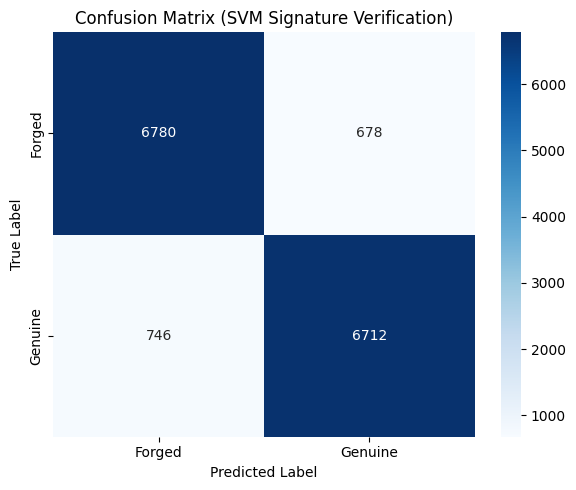

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Forged", "Genuine"],
            yticklabels=["Forged", "Genuine"])
plt.title("Confusion Matrix (SVM Signature Verification)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [13]:
import joblib

In [24]:
joblib.dump(svm_best, "model.pkl")

['model.pkl']


In [25]:
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']
